# Imports 

In [2]:
import pandas as pd
import numpy as np
import os 
current_folder = os.getcwd()
print(current_folder)
parent_folder = os.path.dirname(current_folder)
os.chdir(parent_folder)

/home/araceli/code/energy-analysis-and-predictions/notebooks


In [82]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from load_data.load_green_energy_data import load_green_energy_data
from load_data.get_season_data import get_dict_of_seasons, get_seasonal_power_avg_per_hour
from utils.parameters import WINTER_START, WINTER_END, \
                        SPRING_START, SPRING_END, \
                        SUMMER_START, SUMMER_END, \
                        AUTUM_START, AUTUM_END    
from visualize_data.plot_seasonal_data import plot_all_seasonal_data_for_one_energy                            
import plotly.graph_objects as go

#colors_fig = px.colors.qualitative.Dark24
from datetime import datetime
from predict_data.create_simple_train_test_data import get_X_y_scaled_and_splited

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Test load one file

In [9]:
folder = 'raw_data/energy-companies/green_energies_DE/Photovoltaik/'
#file = 'Realisierte_Erzeugung_202107060059_202107080059_viertelstunde.csv'
file = 'Realisierte_Erzeugung_201801010000_201801032359_viertelstunde.csv'

df = pd.read_csv(folder+file, delimiter=';', decimal=',')
df.columns = ['Datum', 'Anfang', 'Ende', 'Photovoltaik [MWh]']
print(df.shape)
df.head(n=24)

(288, 4)


,Datum,Anfang,Ende,Photovoltaik [MWh]
0,01.01.2018,00:00,00:15,0
1,01.01.2018,00:15,00:30,0
2,01.01.2018,00:30,00:45,0
3,01.01.2018,00:45,01:00,0
4,01.01.2018,01:00,01:15,0
5,01.01.2018,01:15,01:30,0
6,01.01.2018,01:30,01:45,0
7,01.01.2018,01:45,02:00,0
8,01.01.2018,02:00,02:15,0
9,01.01.2018,02:15,02:30,0


In [6]:
type(df['Photovoltaik [MWh]'][0])

str

In [14]:
df['Photovoltaik [MWh]'].dtype=='float64'

True

In [7]:
#df_test['Timestamp'] = pd.to_datetime(df_test['Datum'] + ' ' + df_test['Ende'], format='%m.%d.%Y %H:%M')
df['Timestamp'] = pd.to_datetime(df['Datum'] + ' ' + df['Ende'], format='%d.%m.%Y %H:%M')
df.head()

,Datum,Anfang,Ende,Photovoltaik [MWh],Timestamp
0,06.07.2021,01:00,01:15,0,2021-07-06 01:15:00
1,06.07.2021,01:15,01:30,0,2021-07-06 01:30:00
2,06.07.2021,01:30,01:45,0,2021-07-06 01:45:00
3,06.07.2021,01:45,02:00,0,2021-07-06 02:00:00
4,06.07.2021,02:00,02:15,0,2021-07-06 02:15:00


In [32]:
df.tail()

,Datum,Anfang,Ende,Photovoltaik [MWh],Timestamp
283,03.01.2018,22:45,23:00,0,2018-01-03 23:00:00
284,03.01.2018,23:00,23:15,0,2018-01-03 23:15:00
285,03.01.2018,23:15,23:30,0,2018-01-03 23:30:00
286,03.01.2018,23:30,23:45,0,2018-01-03 23:45:00
287,03.01.2018,23:45,00:00,0,2018-01-03 00:00:00


In [8]:
df = df.drop(columns=['Datum','Anfang', 'Ende'])

In [10]:
def clean_column_dataframe(df: pd.DataFrame, col:str):
    df[col] = df[col].str.replace('.', '')
    df[col] = df[col].str.replace(',', '.')
    df[col] = df[col].replace('-', np.nan)
    df[col] = df[col].astype('float64')
    #df[col] = df[col]/1000 # true scale
    return df

df = clean_column_dataframe(df, 'Photovoltaik [MWh]')
df.dtypes

/tmp/ipykernel_8951/294305874.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace('.', '')


Photovoltaik [MWh]           float64
Timestamp             datetime64[ns]
dtype: object

In [11]:
df.head()

,Photovoltaik [MWh],Timestamp
0,0.0,2021-07-06 01:15:00
1,0.0,2021-07-06 01:30:00
2,0.0,2021-07-06 01:45:00
3,0.0,2021-07-06 02:00:00
4,0.0,2021-07-06 02:15:00


<AxesSubplot:xlabel='Timestamp'>

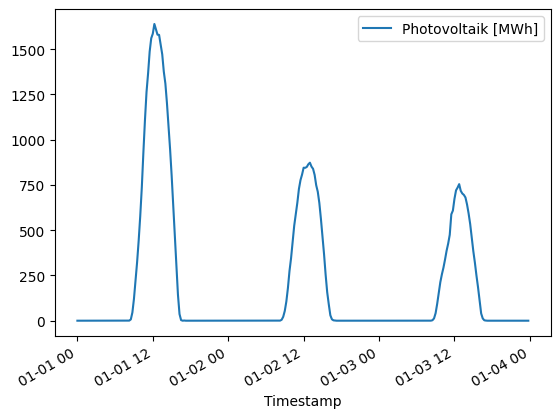

In [6]:
df.plot(x='Timestamp', y='Photovoltaik [MWh]')

In [7]:
for col in list(df.columns):
    print(col)
    print(df[col].isna().value_counts()*100/df.shape[0])
    print('\n')

Photovoltaik [MWh]
False    100.0
Name: Photovoltaik [MWh], dtype: float64


Timestamp
False    100.0
Name: Timestamp, dtype: float64




# sum up to hours 

In [61]:
df['Timestamp'] = pd.to_datetime(df['Datum'] + ' ' + df['Ende'], format='%d.%m.%Y %H:%M')
# df['Datum'] = pd.to_datetime(df['Datum'], format='%d.%m.%Y')
# df['Anfang'] = pd.to_datetime(df['Anfang'], format='%H:%M')
# df['Ende'] = pd.to_datetime(df['Ende'], format='%H:%M')
df = df.drop(columns=['Datum','Anfang', 'Ende'])
df = clean_column_dataframe(df, 'Photovoltaik [MWh]')
df.dtypes

/tmp/ipykernel_1804/294305874.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace('.', '')


Photovoltaik [MWh]           float64
Timestamp             datetime64[ns]
dtype: object

In [57]:
df.head()

,Photovoltaik [MWh],Timestamp
0,0.0,2018-01-01 00:15:00
1,0.0,2018-01-01 00:30:00
2,0.0,2018-01-01 00:45:00
3,0.0,2018-01-01 01:00:00
4,0.0,2018-01-01 01:15:00


In [41]:
df.set_index('Timestamp', inplace=True)
df.head()

,Photovoltaik [MWh]
Timestamp,
2018-01-01 00:15:00,0.0
2018-01-01 00:30:00,0.0
2018-01-01 00:45:00,0.0
2018-01-01 01:00:00,0.0
2018-01-01 01:15:00,0.0


In [62]:
#df_hour = df[['Photovoltaik [MWh]']].groupby(df.index // 4).sum()

dict_grouping = {'Timestamp': 'last',  'Photovoltaik [MWh]': 'sum'}
df = df.groupby(df.index // 4).agg(dict_grouping)
#df_hour = df.groupby(df['Photovoltaik [MWh]'] // 4).cumsum()
df.tail(n=24)

,Timestamp,Photovoltaik [MWh]
48,2018-01-03 01:00:00,0.00
49,2018-01-03 02:00:00,0.00
50,2018-01-03 03:00:00,0.00
51,2018-01-03 04:00:00,0.00
52,2018-01-03 05:00:00,0.00
53,2018-01-03 06:00:00,0.00
54,2018-01-03 07:00:00,0.00
55,2018-01-03 08:00:00,0.00
56,2018-01-03 09:00:00,57.00
57,2018-01-03 10:00:00,715.00


# Test load function

In [73]:
solar_energy = load_green_energy_data('Photovoltaik')
solar_energy.head()

/home/araceli/code/energy-analysis-and-predictions/load_data/load_energy_produced_by_companies.py:94: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

/home/araceli/code/energy-analysis-and-predictions/load_data/load_energy_produced_by_companies.py:94: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

/home/araceli/code/energy-analysis-and-predictions/load_data/load_energy_produced_by_companies.py:94: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

/home/araceli/code/energy-analysis-and-predictions/load_data/load_energy_produced_

,Timestamp,Photovoltaik [MWh]
0,2022-02-05 01:00:00,0.0
1,2022-02-05 02:00:00,0.0
2,2022-02-05 03:00:00,0.0
3,2022-02-05 04:00:00,0.0
4,2022-02-05 05:00:00,0.0


# Test solar energy

In [59]:
#solar_energy.plot(x='Timestamp', y='Photovoltaik [MWh]')
fig = go.Figure()
fig.add_trace(go.Scatter(x=solar_energy['Timestamp'], y=solar_energy['Photovoltaik [MWh]'],
                             line_color='rgba(18,85,194,082)',
                             name='Photovoltaik [MWh]')) # black


fig.update_layout(
    title=go.layout.Title(text='Photovoltaik [MWh]'),
    xaxis_title='Timestamp',
    yaxis_title='MWh')

# Load all seasons data per hour for Photovoltaik

In [60]:
seasons_data = get_dict_of_seasons(solar_energy, 'Photovoltaik')

min_year 2018-01-01 00:00:00
max_year 2023-03-21 23:00:00
[2018, 2019, 2020, 2021, 2022, 2023]
new start val 2017-12-21 1:00:00
Winter date_start = 2017-12-21 01:00:00
Winter date_end = 2018-03-20 00:00:00
seasonal_df
  Timestamp  Photovoltaik [MWh]
0  01:00:00                 0.0
1  02:00:00                 0.0


Spring date_start = 2018-03-21 01:00:00
Spring date_end = 2018-06-20 00:00:00
seasonal_df
  Timestamp  Photovoltaik [MWh]
0  01:00:00                 0.0
1  02:00:00                 0.0


Summer date_start = 2018-06-21 01:00:00
Summer date_end = 2018-09-21 00:00:00
seasonal_df
  Timestamp  Photovoltaik [MWh]
0  01:00:00                 0.0
1  02:00:00                 0.0


Autum date_start = 2018-09-22 01:00:00
Autum date_end = 2018-12-20 00:00:00
seasonal_df
  Timestamp  Photovoltaik [MWh]
0  01:00:00                 0.0
1  02:00:00                 0.0


new start val 2018-12-21 1:00:00
Winter date_start = 2018-12-21 01:00:00
Winter date_end = 2019-03-20 00:00:00
seasonal_df

In [61]:
seasons_data['Winter_2018']

,Timestamp,Photovoltaik [MWh]
0,01:00:00,0.000000
1,02:00:00,0.000000
2,03:00:00,0.000000
3,04:00:00,0.000000
4,05:00:00,0.000000
5,06:00:00,0.000000
6,07:00:00,10.109375
7,08:00:00,386.042969
8,09:00:00,2051.486328
9,10:00:00,4829.845703


# Plot all seasonal data for Photovoltaik

In [62]:
plot_all_seasonal_data_for_one_energy(seasons_data,'Photovoltaik') 

# predict new values for solar energy

In [77]:
solar_df = solar_energy.copy()

In [78]:
solar_energy_df = solar_df.set_index('Timestamp')
solar_energy_df.head()

,Photovoltaik [MWh]
Timestamp,
2022-02-05 01:00:00,0.0
2022-02-05 02:00:00,0.0
2022-02-05 03:00:00,0.0
2022-02-05 04:00:00,0.0
2022-02-05 05:00:00,0.0


In [80]:
solar_energy_df.shape

(33480, 1)

In [84]:
solar_energy_df.isna().value_counts(normalize=True)

Photovoltaik [MWh]
False                 1.0
dtype: float64

In [83]:
split_ratio = 0.9
memory_split_ratio = 0.011
stride_ratio = 0.2
target = solar_energy.columns[0]
scale_range_min = 0.0
scale_range_max = 1
X_train, y_train, X_test, y_test, scaler = get_X_y_scaled_and_splited(solar_energy,
                               split_ratio,
                               memory_split_ratio,
                               stride_ratio,
                               target, 0, 1) 

TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>)

In [ ]:
units_gru_layers = 32
regularizer = None
penalty = 0
activation_function = 'tanh'
opt_compiler = 'adam'
model_metric = 'mae'
patience = 25
epochs = 100
batch_size = 32
foldername = 'raw_data/saved_models'
filename_model = f'model_gru_units_{units_gru_layers}_{regularizer}_{activation_function}_{opt_compiler}_{model_metric}_epochs_{epochs}_bsize_{batch_size}.h5'
folder_model = foldername + '/' + filename_model

# Wind Onshore

In [63]:
wind_onshore = load_green_energy_data('Wind_Onshore')
wind_onshore.head()

/home/araceli/code/energy-analysis-and-predictions/load_data/load_energy_produced_by_companies.py:94: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

/home/araceli/code/energy-analysis-and-predictions/load_data/load_energy_produced_by_companies.py:94: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

/home/araceli/code/energy-analysis-and-predictions/load_data/load_energy_produced_by_companies.py:94: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

/home/araceli/code/energy-analysis-and-predictions/load_data/load_energy_produced_

,Timestamp,Wind_Onshore [MWh]
0,2018-01-01 01:00:00,28503.50
1,2018-01-01 02:00:00,29638.00
2,2018-01-01 03:00:00,30173.75
3,2018-01-01 04:00:00,31021.50
4,2018-01-01 05:00:00,31015.00


In [64]:
seasons_wind_onshore = get_dict_of_seasons(wind_onshore, 'Wind_Onshore')

min_year 2018-01-01 00:00:00
max_year 2021-01-17 23:00:00
[2018, 2019, 2020, 2021]
new start val 2017-12-21 1:00:00
Winter date_start = 2017-12-21 01:00:00
Winter date_end = 2018-03-20 00:00:00
seasonal_df
  Timestamp  Wind_Onshore [MWh]
0  01:00:00        13923.910377
1  02:00:00        13812.740566


Spring date_start = 2018-03-21 01:00:00
Spring date_end = 2018-06-20 00:00:00
seasonal_df
  Timestamp  Wind_Onshore [MWh]
0  01:00:00         9315.442623
1  02:00:00         8876.852459


Summer date_start = 2018-06-21 01:00:00
Summer date_end = 2018-09-21 00:00:00
seasonal_df
  Timestamp  Wind_Onshore [MWh]
0  01:00:00         6550.995763
1  02:00:00         6870.597458


Autum date_start = 2018-09-22 01:00:00
Autum date_end = 2018-12-20 00:00:00
seasonal_df
  Timestamp  Wind_Onshore [MWh]
0  01:00:00         14439.90000
1  02:00:00         14239.79661


new start val 2018-12-21 1:00:00
Winter date_start = 2018-12-21 01:00:00
Winter date_end = 2019-03-20 00:00:00
seasonal_df
  Timestamp

In [40]:
seasons_wind_onshore.keys()

dict_keys(['Winter_2017', 'Spring_2018', 'Summer_2018', 'Autum_2018', 'Winter_2019', 'Spring_2019', 'Summer_2019', 'Autum_2019', 'Winter_2020', 'Spring_2020', 'Summer_2020', 'Autum_2020'])

In [55]:
print(wind_onshore['Timestamp'].min().year)
print(f'{wind_onshore.Timestamp.min().month}-{wind_onshore.Timestamp.min().day}')
winter = [12,1,2,3]
spring = [3,4,5,6]
summer = [6,7,8,9]
autum =  [9,10,11,12]

min_month = wind_onshore.Timestamp.min().month
min_day = wind_onshore.Timestamp.min().day
dict_seasons = {'Winter':winter, 'Spring':spring, 'Summer':summer, 'Autum':autum}

season = ''

for key,value in dict_seasons.items():
    print(key)
    if min_month in value:        
        if min_month == value[0] and min_day >= 21:
            print('min month in season, at the begining')
            season = key
        if min_month >= value[1] and min_month < value[-1]:
            season = key
            print('min month in season, in the middle')
        if min_month == value[-1] and min_day<21:
            season = key
            print('min month in season, at the end')
season

2018
1-1
Winter
min month in season, in the middle
Spring
Summer
Autum


'Winter'

In [54]:
winter[-2]

2

## Plots Wind onshore per 24 h 

In [57]:
plot_all_seasonal_data_for_one_energy(seasons_wind_onshore,'Wind_Onshore') 

In [65]:
seasons_wind_onshore['Winter_2020']

,Timestamp,Wind_Onshore [MWh]
0,01:00:00,18991.654167
1,02:00:00,18879.858333
2,03:00:00,18801.658333
3,04:00:00,18790.458333
4,05:00:00,18720.700000
5,06:00:00,18659.250000
6,07:00:00,18956.404167
7,08:00:00,18739.387500
8,09:00:00,18375.545833
9,10:00:00,17920.716667


In [26]:
# conditon= wind_onshore['Timestamp'] 
# wind_onshore
date_start = '2019-12-21 0:00'
date_end = '2020-03-21 1:00'
df = wind_onshore.loc[(wind_onshore['Timestamp'] >= date_start) & (wind_onshore['Timestamp'] <= date_end)]
df.head()

,Timestamp,Wind_Onshore [MWh]
24,2019-12-21 01:00:00,18911.25
25,2019-12-21 02:00:00,18933.00
26,2019-12-21 03:00:00,18526.75
27,2019-12-21 04:00:00,18197.00
28,2019-12-21 05:00:00,16559.00


In [35]:
df2 = get_seasonal_power_avg_per_hour(wind_onshore, 'Wind_Onshore', date_start, date_end)
df2

,Timestamp,Wind_Onshore [MWh]
0,01:00:00,18731.540984
1,02:00:00,18623.225410
2,03:00:00,18547.340164
3,04:00:00,18536.848361
4,05:00:00,18469.352459
5,06:00:00,18413.922131
6,07:00:00,18708.483607
7,08:00:00,18495.127049
8,09:00:00,18132.713115
9,10:00:00,17685.573770
